In [1]:
import numpy as np
import pandas as pd
import os

from datasets import load_dataset, DatasetDict

import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

import matplotlib.pyplot as plt

In [2]:
INPUT_DIR = "/input0"
OUTPUT_DIR = "/output/output/bert"
CHECKPOINT = "google-bert/bert-base-multilingual-uncased"

In [3]:
# Load data
data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")
data = data.train_test_split(0.2)

data = DatasetDict(
    {
        "train": data["train"],
        "val": data["test"],
        "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
    }
)
data

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 9696
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [4]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=3)
model

import torch
import torch.nn as nn

class CNNCls(nn.Module):
    def __init__(self):
        super(CNNCls, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


model.classifier = CNNCls()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def preprocess_data(batch):
    batch["text"] = [
        x1 + f" {tokenizer.sep_token} " + x2
        for x1, x2 in zip(batch["premise"], batch["hypothesis"])
    ]
    return tokenizer(batch["text"])

data = data.map(preprocess_data, batched=True)

Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

In [6]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)


train_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "results"),
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    report_to=[],
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    save_steps=200,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=5,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=3,
    save_only_model=True,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(3)],
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,1.099800,1.071912,0.444719
400,1.015700,0.980441,0.518564
600,0.960700,0.940750,0.585396
800,0.860900,0.919745,0.594472
1000,0.848300,0.889830,0.596122
1200,0.851900,0.872828,0.606023
1400,0.683200,0.889967,0.625000
1600,0.688400,0.910510,0.616749
1800,0.678200,0.900220,0.619637
2000,0.552800,0.950161,0.627888


TrainOutput(global_step=3030, training_loss=0.7106497153984045, metrics={'train_runtime': 226.4179, 'train_samples_per_second': 214.117, 'train_steps_per_second': 13.382, 'total_flos': 2203376327243616.0, 'train_loss': 0.7106497153984045, 'epoch': 5.0})

In [8]:
log = trainer.state.log_history

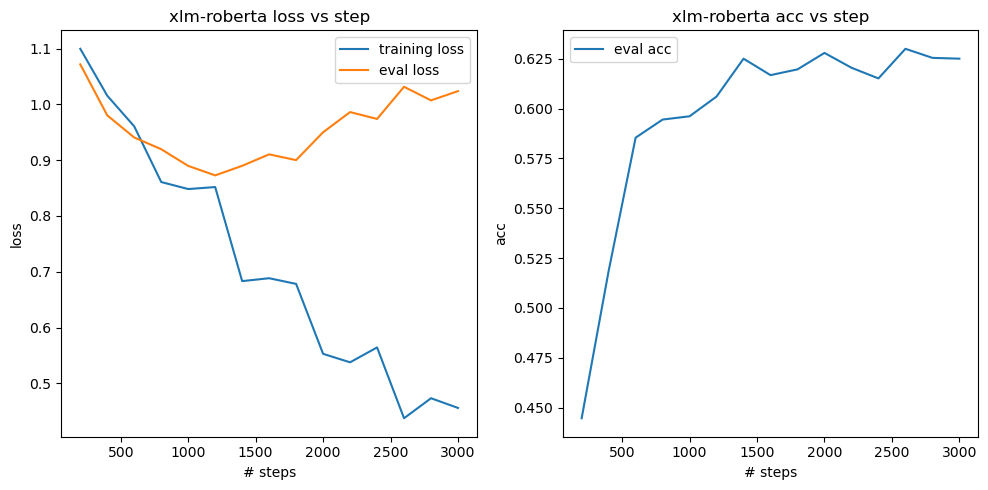

In [9]:
steps = []
train_loss = []
eval_loss = []
eval_acc = []

for i in range(0, len(log) - 1, 2):
    train_log = log[i]
    eval_log = log[i + 1]
    steps.append(train_log["step"])
    train_loss.append(train_log["loss"])
    eval_loss.append(eval_log["eval_loss"])
    eval_acc.append(eval_log["eval_accuracy"])

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title("xlm-roberta loss vs step")
plt.xlabel("# steps")
plt.ylabel("loss")
plt.plot(steps, train_loss, label="training loss")
plt.plot(steps, eval_loss, label="eval loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("xlm-roberta acc vs step")
plt.xlabel("# steps")
plt.ylabel("acc")
plt.plot(steps, eval_acc, label="eval acc")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
preds = trainer.predict(data["test"])

In [11]:
pd.DataFrame(
    {"id": data["test"]["id"], "prediction": np.argmax(preds.predictions, axis=1)}
).to_csv(os.path.join(OUTPUT_DIR, "submission.csv"), header=True, index=False)